# Example of context

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import multihist as mh

import GOFevaluation

import appletree as apt
from appletree.utils import get_file_path

In [2]:
apt.set_gpu_memory_usage(0.2)

## Define context

In [3]:
# Load configuration file
config = get_file_path('rn220.json')

# Initialize context
tree = apt.Context(config)

In [4]:
# To see all the likelihoods

tree.print_context_summary(short=True)


LIKELIHOOD rn220_llh

----------------------------------------
BINNING

    bins_type: equiprob
    bins_on: ['cs1', 'cs2']

----------------------------------------
DATA

    file_name: data_Rn220.csv
    data_rate: 2000.0

----------------------------------------
MODEL

    COMPONENT 0: rn220_er
        type: simulation
        rate_par: rn220_er_rate
        pars: {'rf0', 'gas_gain', 'g2', 'py1', 'g1', 'py4', 'py0', 'py2', 'rf1', 'field', 'nex_ni_ratio', 'drift_velocity', 'p_dpe', 'w', 'rn220_er_rate', 'py3', 'fano', 's2_threshold'}

    COMPONENT 1: rn220_ac
        type: fixed
        file_name: AC_Rn220.pkl
        rate_par: rn220_ac_rate
        pars: {'rn220_ac_rate'}

----------------------------------------



## Fit, run the MCMC

In [5]:
result = tree.fitting(nwalkers=100, iteration=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


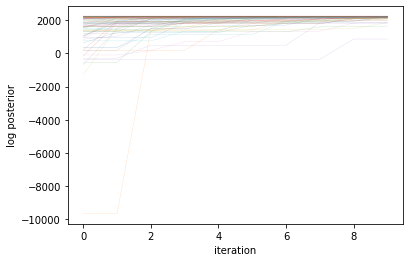

In [6]:
logp = tree.sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.xlabel('iteration')
plt.ylabel('log posterior')
plt.show()

## Generate templates

In [7]:
cs1, cs2, eff = tree.get_template('rn220_llh', 'rn220_er')

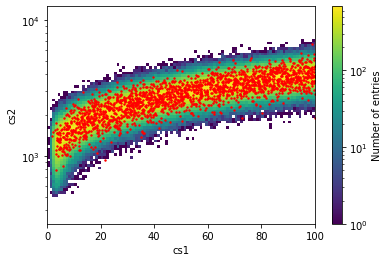

In [8]:
h, be = jnp.histogramdd(
    jnp.asarray([cs1, cs2]).T, 
    bins=(jnp.linspace(0, 100, 101), jnp.logspace(2.5, 4.1, 81)), 
    weights=eff
)

h = mh.Histdd.from_histogram(
    np.array(h), 
    be, 
    axis_names=['cs1', 'cs2']
)
h.plot(norm=LogNorm())
plt.scatter(*tree['rn220_llh'].data.T, color='r', s=2.0)
plt.yscale('log')
plt.show()

In [9]:
parameters = tree.get_post_parameters()
key = apt.randgen.get_key()
batch_size = int(1e6)

In [10]:
key, result = tree['rn220_llh']['rn220_er'].simulate(
    key, 
    batch_size, parameters
)

/opt/miniconda3/envs/XENONnT_2022.06.2/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


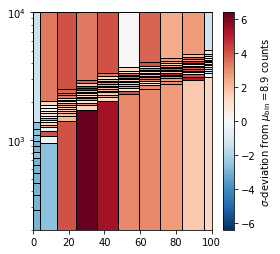

In [11]:
data_sample = np.array(result[:-1]).T
x_clip = tree['rn220_llh']._config['x_clip']
y_clip = tree['rn220_llh']._config['y_clip']

n, bin_edges = GOFevaluation.utils.equiprobable_histogram(
    tree['rn220_llh'].data, 
    data_sample, 
    tree['rn220_llh']._config['bins'], 
    order=[0, 1], 
    plot=True, 
    nevents_expected=len(tree['rn220_llh'].data), 
    plot_xlim=x_clip,  
    plot_ylim=y_clip, 
    plot_mode='sigma_deviation'
)
plt.yscale('log')

## Number of events in equal-probability binning

In [12]:
key, h = tree['rn220_llh']['rn220_er'].simulate_hist(
    key, 
    batch_size, parameters
)

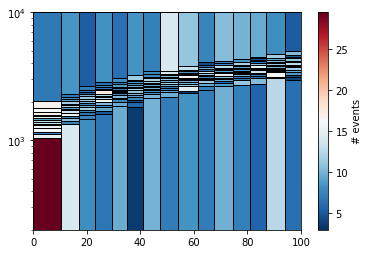

In [13]:
apt.utils.plot_irreg_histogram_2d(*tree['rn220_llh']['rn220_er'].bins, h, density=False)
plt.yscale('log')

plt.show()